In [1]:
import numpy as np
import seaborn as sns
from scipy.special import expit as sigmoid
import matplotlib.pyplot as plt

In [2]:
class DistanceDistribution:
    def __init__(self):
        super(DistanceDistribution, self).__init__()
        
    def _sample_s(self, n, fraction_protected):
        s = (
            np.random.rand(n, 1) < fraction_protected
        ).astype(int)

        zeros_as_negative_one = s - 1
        s += zeros_as_negative_one
        return s
    
    def _increase_variance(self, s, distance, stddev_multiplier):
        changed_distance = distance.copy()
        indices = np.array(range(0, s.shape[0]))
        s_1 = indices[s.squeeze() == 1]
        changed_distance[s_1] *= stddev_multiplier
        return changed_distance

    def sample_same_stddev_varying_mu(self, n, mu_multiplier, fraction_protected=0.5):
        s = self._sample_s(n, fraction_protected)
        distance = np.random.randn(n, 1) + mu_multiplier*s

        return distance, s
    
    def sample_same_mu_varying_stddev(self, n, stddev_multiplier, fraction_protected=0.5):
        s = self._sample_s(n, fraction_protected)
        distance = np.random.randn(n, 1)
        
        distance = self._increase_variance(s, distance, stddev_multiplier)
        
        return distance, s
    
    def sample_different_mu_varying_stddev(self, n, mu_multiplier, stddev_multiplier, fraction_protected=0.5):
        s = self._sample_s(n, fraction_protected)
        distance = np.random.randn(n, 1)
        
        distance = self._increase_variance(s, distance, stddev_multiplier)
        
        indices = np.array(range(0, s.shape[0]))
        s_1 = indices[s.squeeze() == 1]
        distance[s_1] += mu_multiplier
        
        return distance, s

In [3]:
def calc_covariance(s, distance):
    decisions = sigmoid(distance)
    
    mu_s = np.mean(s, axis=0)

    covariance_distance = (s - mu_s) * distance
    covariance_decision = (s - mu_s) * decisions
    
    return covariance_distance.mean(axis=0), covariance_decision.mean(axis=0)

In [4]:
def plot_results(x, covariances_distance, covariances_decision, xscale='linear'):
    f, axes = plt.subplots(1, 3, figsize=(30, 10), sharex=False)
    sns.lineplot(x=x, y=covariances_distance, ax=axes[0])
    axes[0].set_xscale(xscale)
    axes[0].set_title("Distance")
    
    sns.lineplot(x=x, y=covariances_decision, ax=axes[1])
    axes[1].set_xscale(xscale)
    axes[1].set_title("Decision")
    
    axes[2].set_xscale(xscale)
    sns.lineplot(x=x, y=covariances_distance, ax=axes[2])
    sns.lineplot(x=x, y=covariances_decision, ax=axes[2])
    
def calc(n, range, sampling_fct, verbose=False):
    covariances_distance = []
    covariances_decision = []
    
    if verbose:
        plot_columns = 5
        plot_rows = len(range) // plot_columns    
        if len(range) % plot_columns != 0:
            plot_rows += 1        
        f, axes = plt.subplots(plot_rows, plot_columns, figsize=(20, 10), sharex=False)
        i = 0
        j = 0
        
    for r in range:
        distance, s = sampling_fct(n, r)
        cov_dist, cov_dec = calc_covariance(s, distance)
        covariances_distance.append(cov_dist)
        covariances_decision.append(cov_dec)
        if verbose:
            sns.distplot(distance, ax=axes[j, i])
            
            i = (i + 1) % plot_columns
            if i == 0:
                j += 1
    return np.array(covariances_distance).squeeze(), np.array(covariances_decision).squeeze()

def normalize(x):
    x_min = x.min()
    x_max = x.max()
    
    return (x - x_min)/(x_max - x_min)

def standardize(x):
    stddev = x.std()
    mean = x.mean()
    
    return (x - mean)/stddev

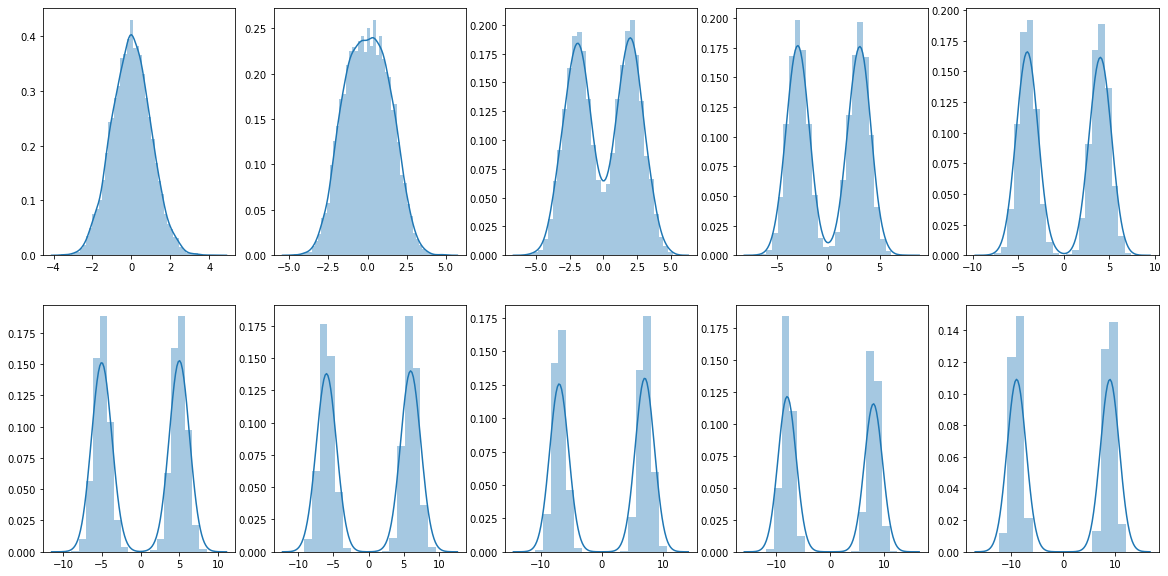

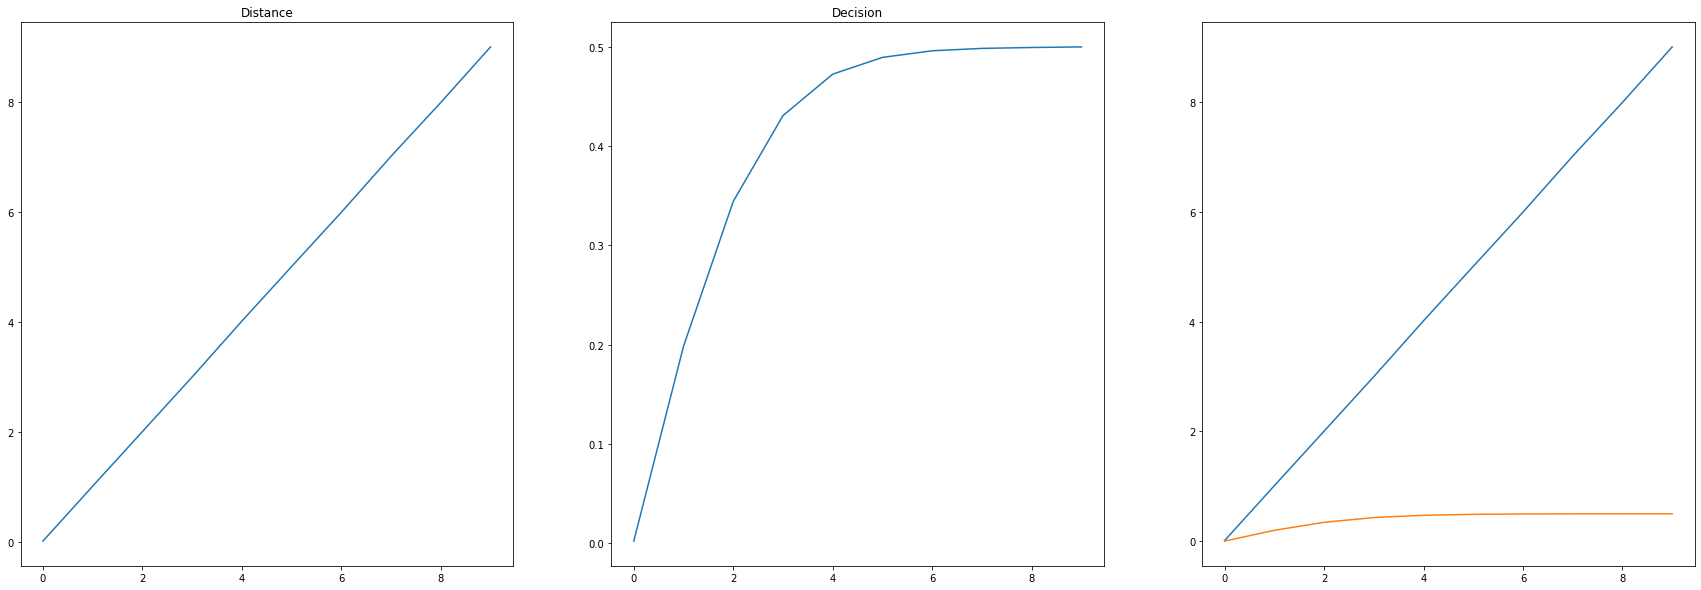

In [31]:
dist = DistanceDistribution()
mu_range = range(0, 10)

covariances_distance, covariances_decision = calc(10000, mu_range, dist.sample_same_stddev_varying_mu, verbose=True)
plot_results(mu_range, covariances_distance, covariances_decision)


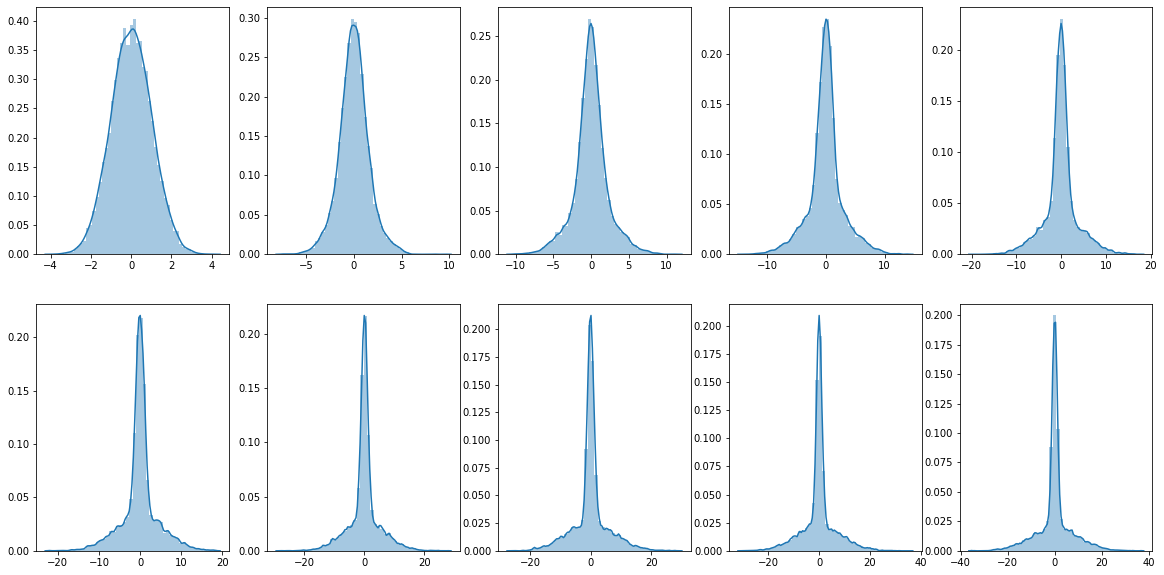

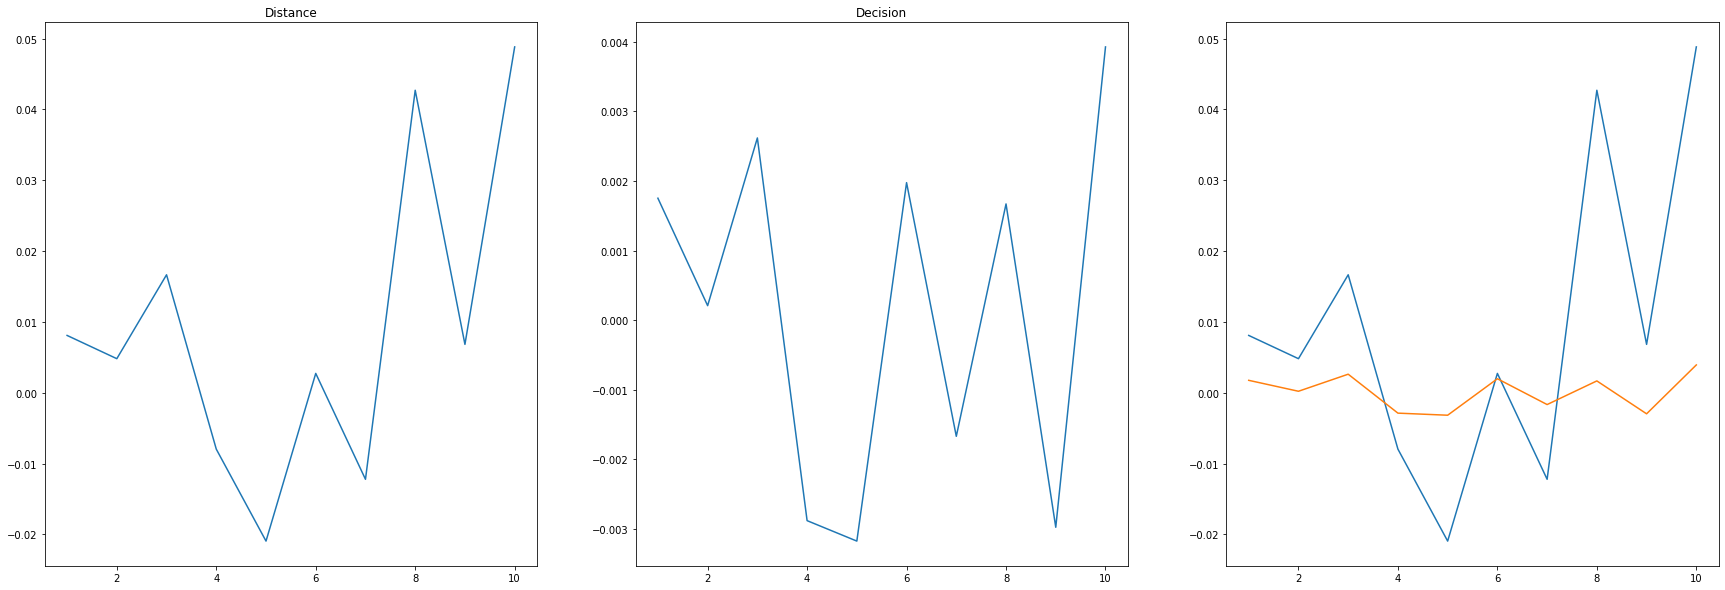

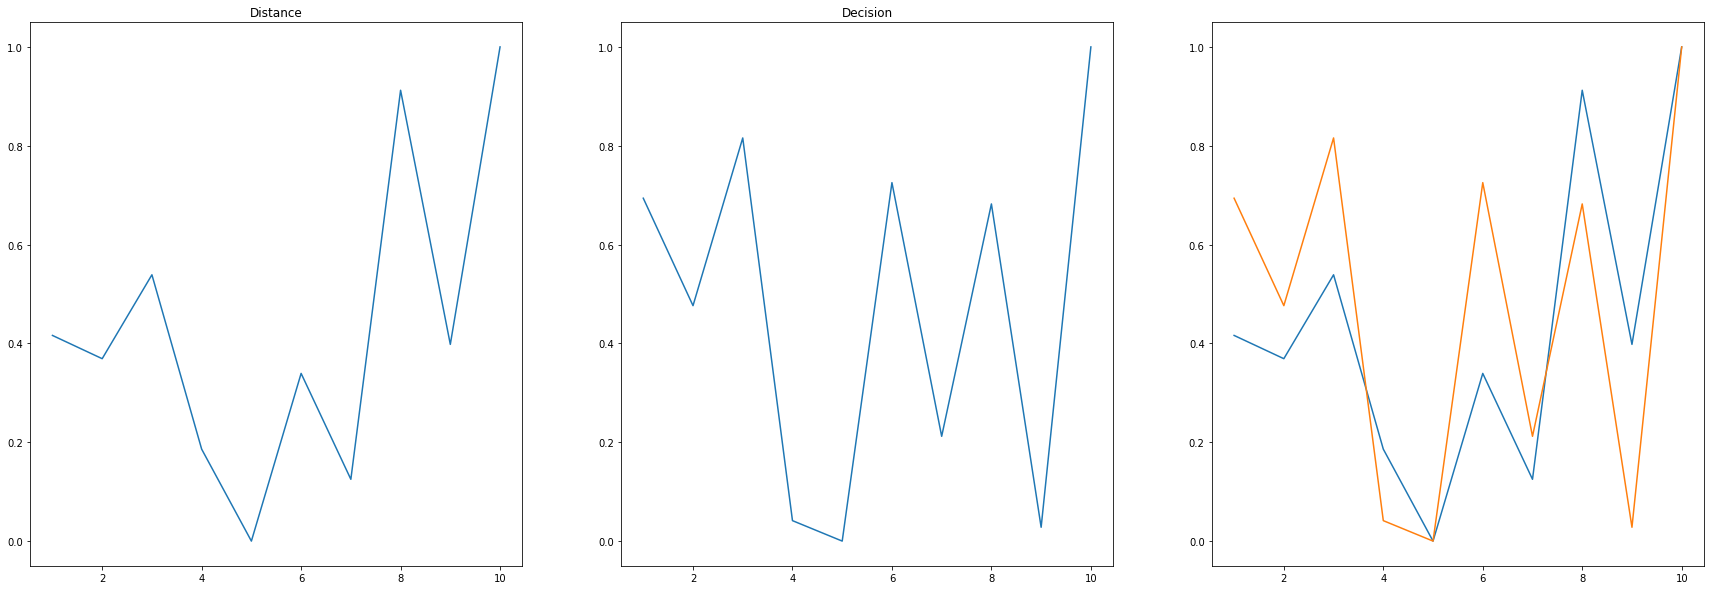

In [33]:
dist = DistanceDistribution()
stddev_range = range(1, 11)
#stddev_range = np.logspace(-1, 1, base=10, endpoint=True, num=30)

covariances_distance, covariances_decision = calc(10000, stddev_range, dist.sample_same_mu_varying_stddev, verbose=True)
#plot_results(stddev_range, covariances_distance, covariances_decision, xscale='log')
#plot_results(stddev_range, normalize(covariances_distance), normalize(covariances_decision), xscale='log')
plot_results(stddev_range, covariances_distance, covariances_decision)
#plot_results(stddev_range, normalize(covariances_distance), normalize(covariances_decision))




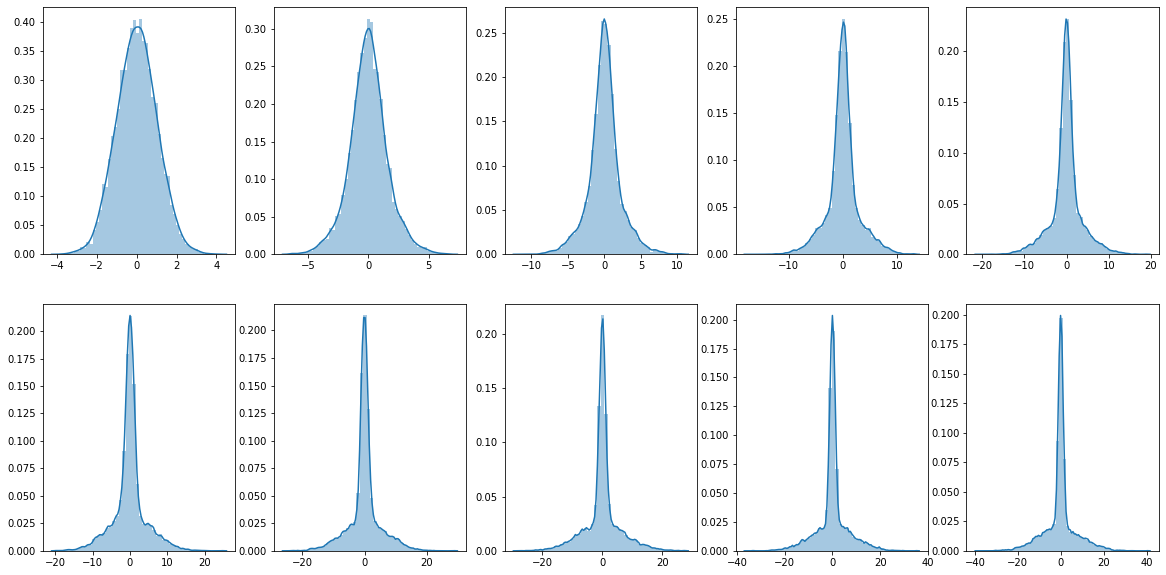

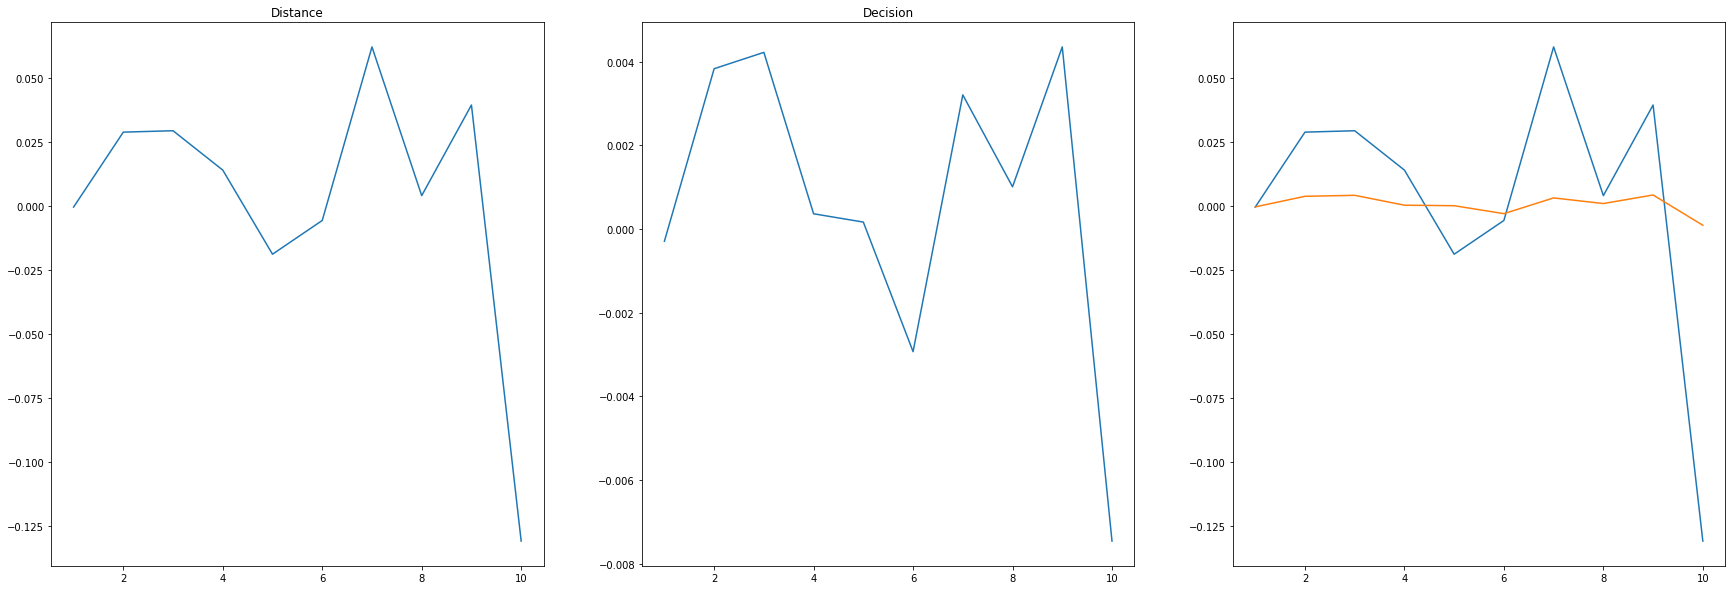

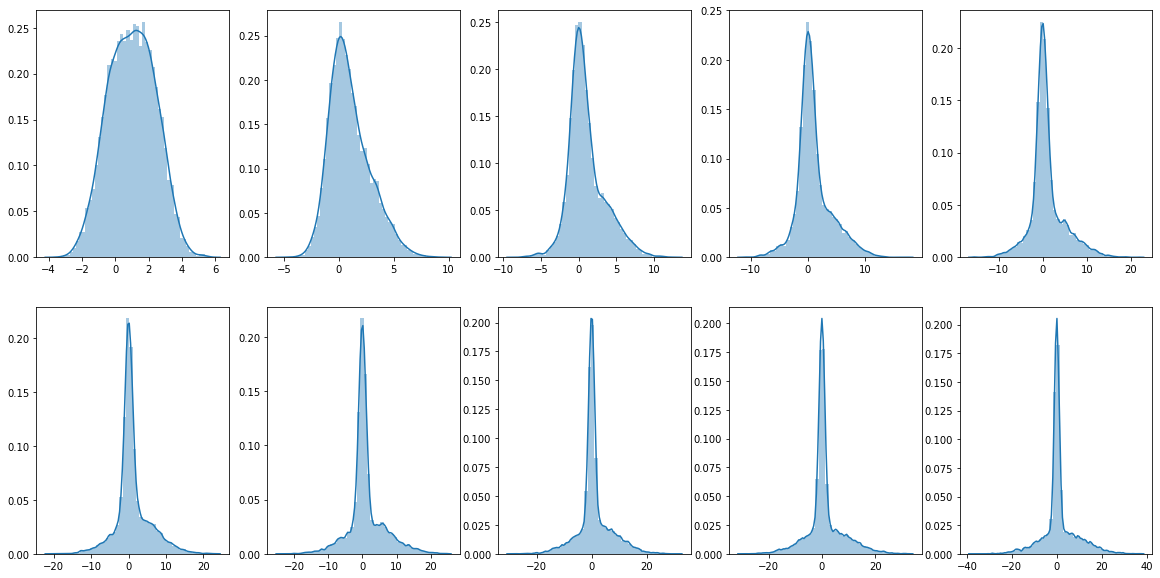

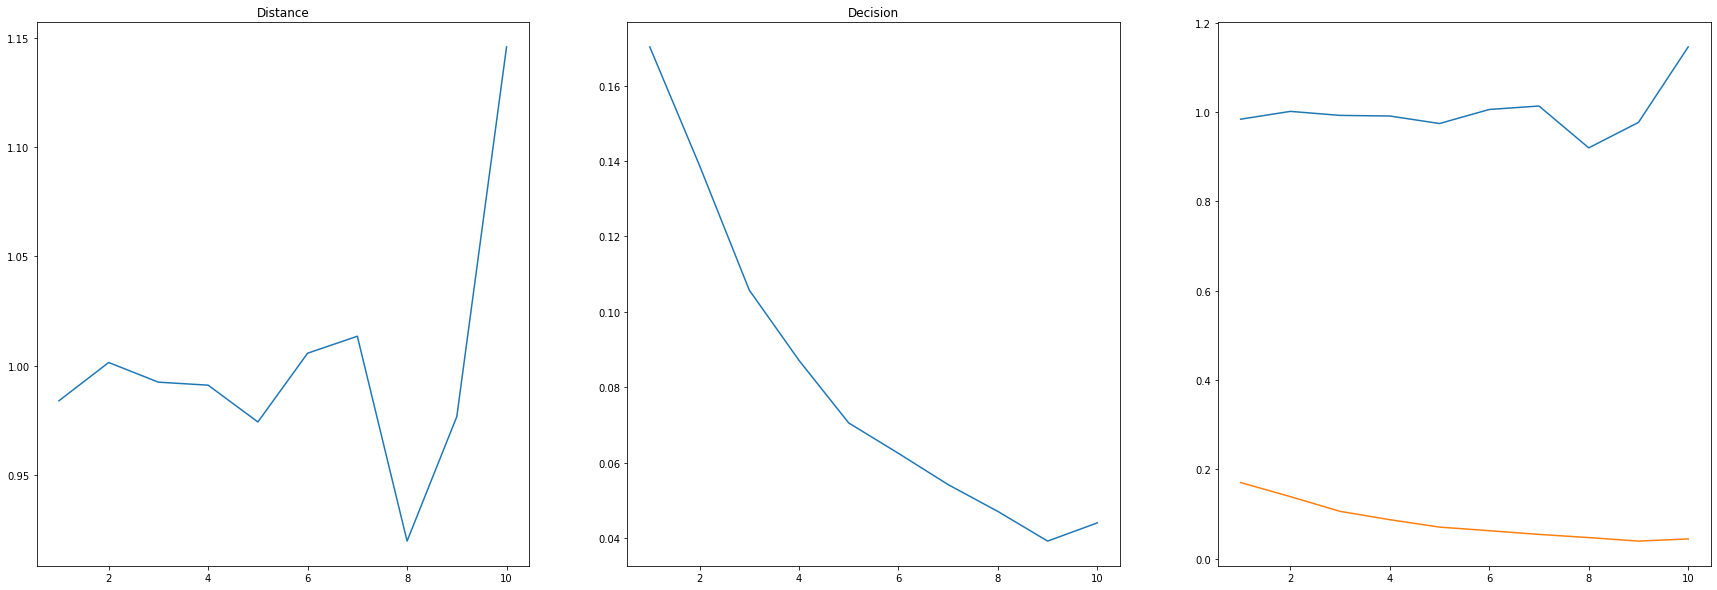

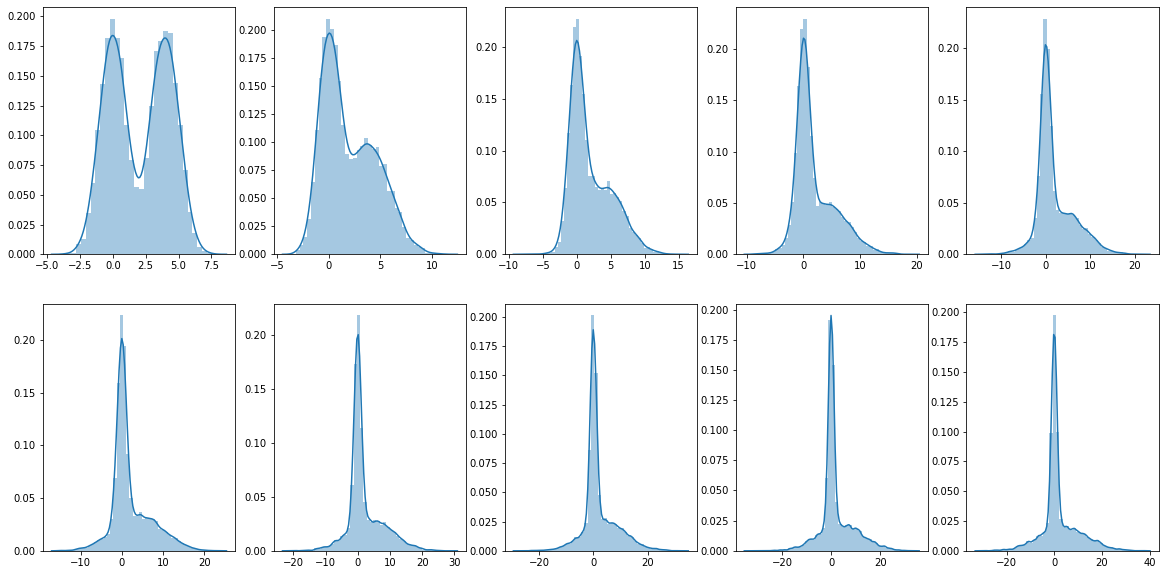

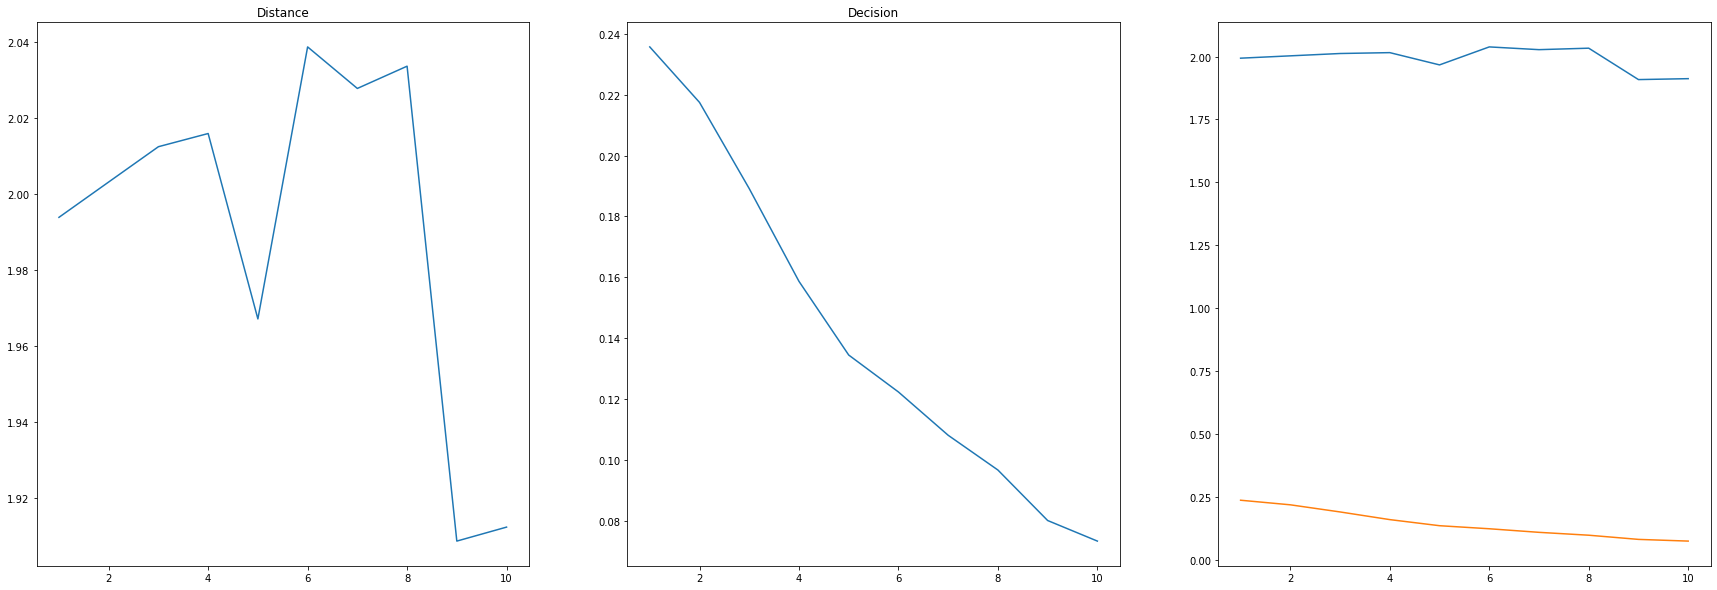

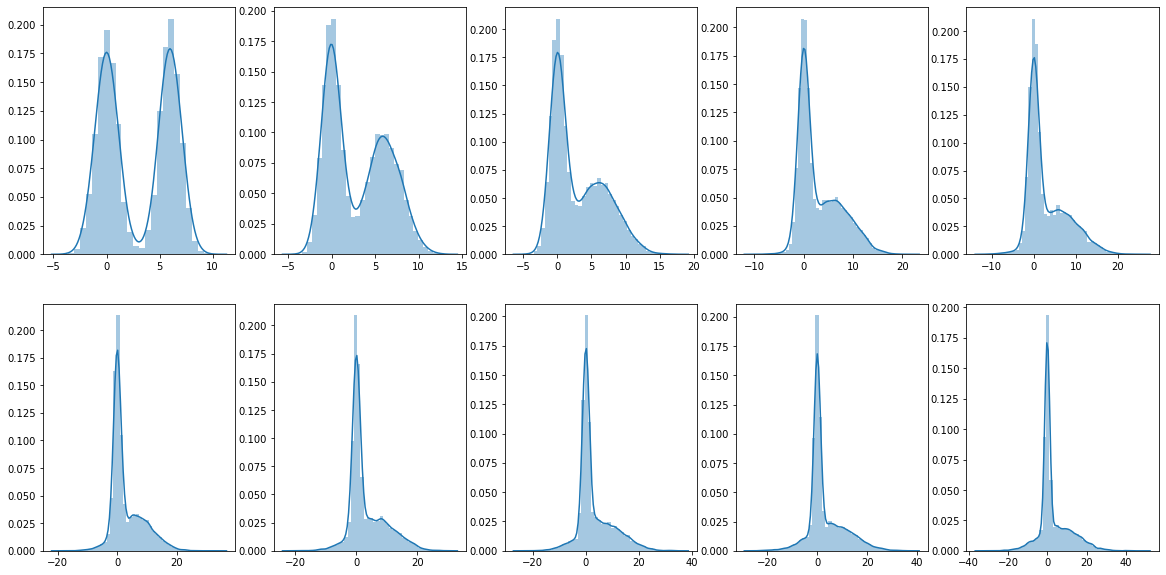

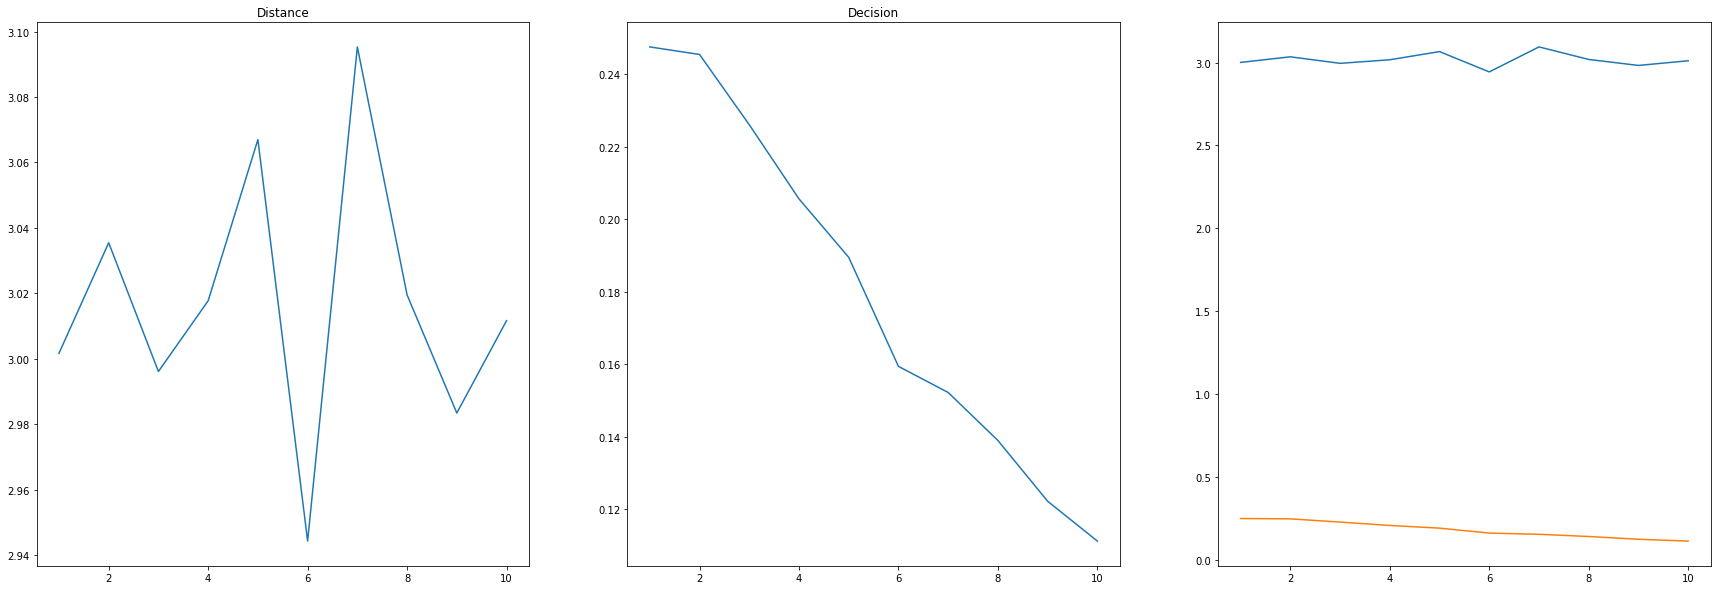

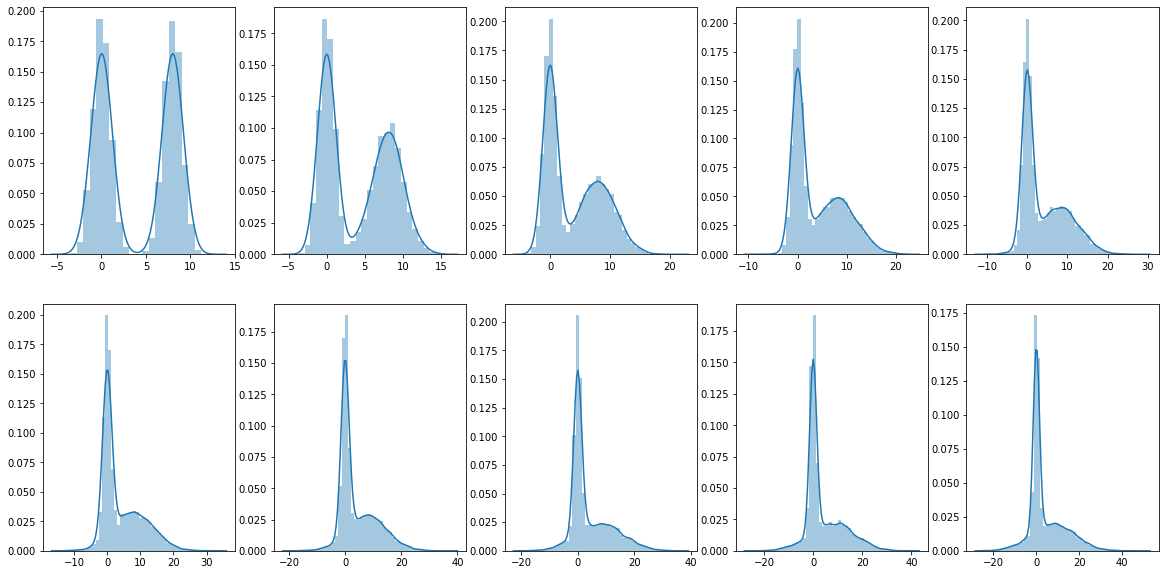

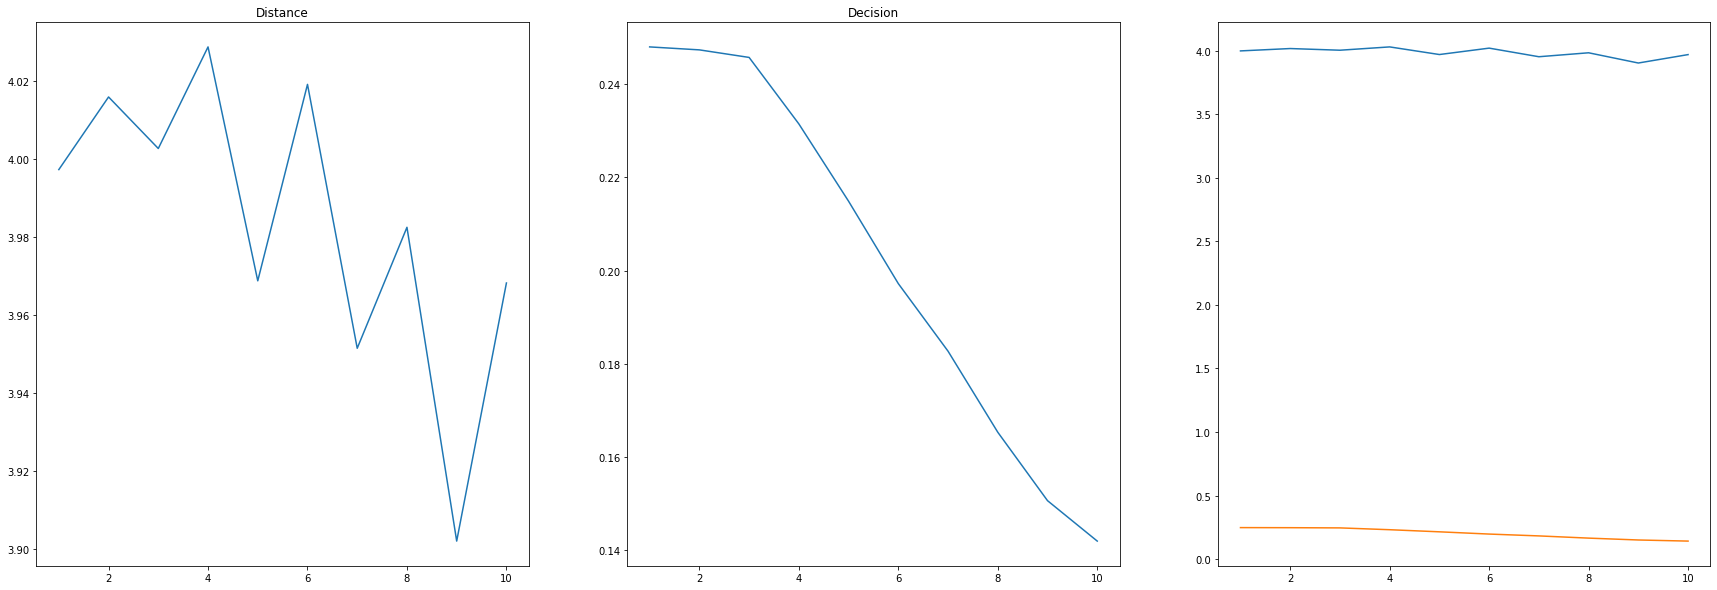

In [5]:
dist = DistanceDistribution()
stddev_range = range(1, 11)
#stddev_range = np.logspace(-1, 1, base=10, endpoint=True, num=30)

for mu in range(0, 10, 2):
    func = lambda n, r : dist.sample_different_mu_varying_stddev(n, mu_multiplier=mu, stddev_multiplier=r)
    covariances_distance, covariances_decision = calc(10000, stddev_range, func, verbose=True)
    #plot_results(stddev_range, covariances_distance, covariances_decision, xscale='log')
    #plot_results(stddev_range, normalize(covariances_distance), normalize(covariances_decision), xscale='log')
    plot_results(stddev_range, covariances_distance, covariances_decision)
    #plot_results(stddev_range, normalize(covariances_distance), normalize(covariances_decision))
